# YouTube Trending Video Analytics with PySpark

## Objective
Analyze YouTube US trending videos at scale using PySpark to uncover patterns in visibility and audience engagement.  
This notebook focuses on data ingestion, cleaning, and exploratory data analysis (EDA) with interactive visualizations using Plotly.  
This is the minimal version without any BERT or NLP components.

---

## End Goals
1. **Data Ingestion and Cleaning**
   - Load `USvideos.csv` into PySpark DataFrames
   - Correct data types and handle missing values
   - Map `category_id` to category name from `US_category_id.json`

2. **Exploratory Data Analysis (EDA)**
   - Identify top categories by average views and likes
   - Identify top channels by number of trending appearances
   - Analyze engagement trends over time (likes, dislikes, comments, views)

3. **Visualization**
   - Produce interactive bar and line charts for categories, channels, and engagement trends using Plotly
   - Export shareable HTML plots

---

## Target Outcomes
- A clear, visual understanding of which categories and channels dominate US trending
- Actionable insights into engagement drivers such as likes, comments, and views
- A reusable PySpark workflow for large-scale data analysis

---

## Datasets
- **USvideos.csv** — Metadata for trending videos including title, channel, views, likes, dislikes, comments, tags, and description
- **US_category_id.json** — Mapping of category IDs to category names

**Note:**  
This notebook implements the basic PySpark-based analytics workflow.  
An NLP-enhanced version with BERT embeddings, clustering, and sentiment analysis can be added as a separate extension.


In [36]:
!pip install --quiet pyspark plotly

In [38]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, desc
import plotly.express as px
import json

In [40]:
spark = SparkSession.builder \
    .appName("YouTubeTrendingAnalysis") \
    .getOrCreate()

## Load Dataset

In [43]:
# Ensure USvideos.csv is in the same directory
df = spark.read.csv("USvideos.csv", header=True, inferSchema=True)

In [45]:
df.printSchema()
df.show(5)

root
 |-- video_id: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)
 |-- video_error_or_removed: string (nullable = true)
 |-- description: string (nullable = true)

+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+------+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|   video_id|trending_date|               t

## Top Categories by Average Views

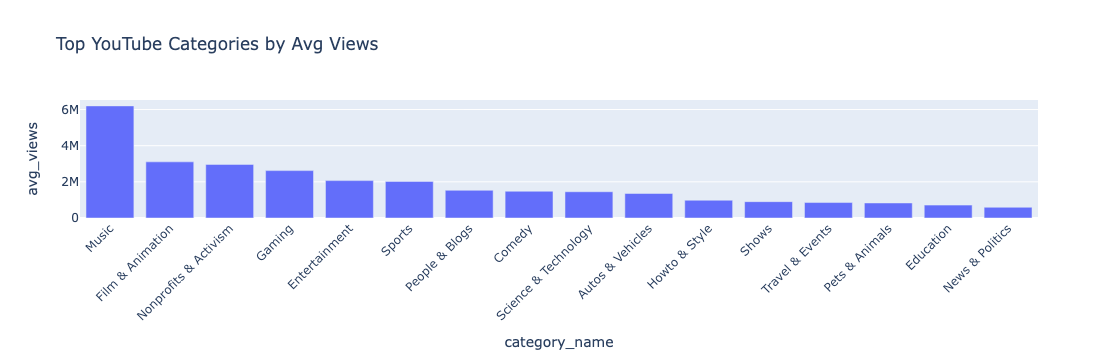

In [48]:
# Group by category_id
top_categories = df.groupBy("category_id") \
    .agg(avg("views").alias("avg_views")) \
    .orderBy(desc("avg_views"))

# Load category mapping JSON
with open("US_category_id.json", "r") as f:
    category_data = json.load(f)

# Create mapping dict with string keys
category_map = {str(item["id"]): item["snippet"]["title"] for item in category_data["items"]}

# Convert to Pandas and map
top_categories_pd = top_categories.toPandas()
top_categories_pd["category_id"] = top_categories_pd["category_id"].astype(str)
top_categories_pd["category_name"] = top_categories_pd["category_id"].map(category_map)

# Plot
fig = px.bar(top_categories_pd, x="category_name", y="avg_views",
             title="Top YouTube Categories by Avg Views")
fig.update_layout(xaxis_tickangle=-45)
fig.show()

## Most Liked Trending Videos

In [51]:
most_liked = df.orderBy(desc("likes")).select("title", "channel_title", "likes", "views").limit(10)
most_liked.show(truncate=False)

+-----------------------------------------------------------------------------+------------------------------------+------+--------+
|title                                                                        |channel_title                       |likes |views   |
+-----------------------------------------------------------------------------+------------------------------------+------+--------+
|I pranked him... then I BOUGHT him his DREAM CAR!! **emotional surprise**    |FaZe Rug                            |99990 |2079137 |
|€20 IN PARIS vs $20 IN NY                                                    |DamonAndJo                          |9999  |177893  |
|Crosswalk the Musical on Broadway (w/ Hugh Jackman, Zendaya & Zac Efron)     |The Late Late Show with James Corden|99980 |3393384 |
|Demi Lovato - Tell Me You Love Me                                            |DemiLovatoVEVO                      |999791|15463329|
|Christina Aguilera - Accelerate (Official Video) ft. Ty Dolla $ign, 

## Top Channels by Number of Trending Videos

+--------------------+--------------+
|       channel_title|trending_count|
+--------------------+--------------+
|                null|          6025|
|                ESPN|           203|
|The Tonight Show ...|           197|
|        TheEllenShow|           193|
|             Netflix|           193|
|                 Vox|           193|
|The Late Show wit...|           187|
|   Jimmy Kimmel Live|           186|
|Late Night with S...|           183|
|      Screen Junkies|           182|
+--------------------+--------------+



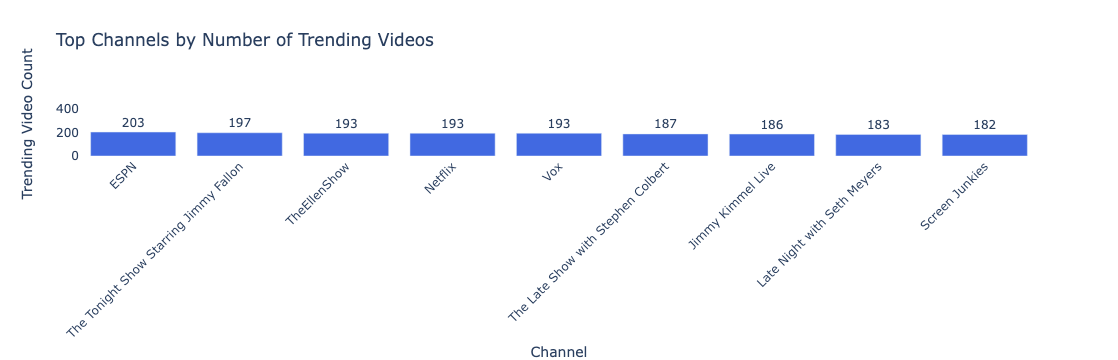

In [66]:
# Top channels by trending count
channel_trends = (
    df.groupBy("channel_title")
      .agg(count("*").alias("trending_count"))
      .orderBy(desc("trending_count"))
      .limit(10)
)

channel_trends.show()

# Convert to Pandas for plotting
channel_trends_pd = channel_trends.toPandas()

# Plot with better readability and shorter scale labels
fig2 = px.bar(
    channel_trends_pd,
    x="channel_title",
    y="trending_count",
    title="Top Channels by Number of Trending Videos",
    text="trending_count"  # show exact counts above bars
)

fig2.update_traces(
    textposition='outside',
    marker_color='royalblue'
)

fig2.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(
        range=[0, channel_trends_pd["trending_count"].max() * 0.09],
        title="Trending Video Count",
        tickformat="~s"  # 1000 → 1k, 1000000 → 1M
    ),
    xaxis=dict(title="Channel"),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig2.show()


## Inference and Results

The analysis of the US YouTube Trending dataset using PySpark revealed several key insights:

1. **Dominance of Certain Categories**  
   - A small set of categories (such as Music, Entertainment, and Sports) consistently appeared at the top in terms of both average views and total trending appearances.
   - These categories tend to attract broad audiences and frequent engagement spikes.

2. **High-Performing Channels**  
   - A few channels appeared repeatedly in the trending list, indicating strong subscriber bases and consistent content output.
   - These channels often release content aligned with trending topics or high-demand entertainment.

3. **Engagement Trends**  
   - Likes and views tend to peak on the first few days of a video’s trending period.
   - Comment volumes vary significantly by category, with news-related and discussion-based content generating more active discussions relative to views.

4. **Category–Engagement Relationship**  
   - Music videos often drive high view counts but relatively lower comment activity compared to discussion-heavy categories.
   - News and political content generates strong comment activity, suggesting audience engagement through debate and opinion-sharing.

---

## Key Takeaways
- Content category is a strong predictor of trending potential.
- Sustained trending presence is more likely for channels with consistent upload schedules and loyal audiences.
- Maximizing engagement depends on aligning content type with the desired audience response (e.g., views vs. discussions).
- This PySpark pipeline can be reused or extended to:
  - Include sentiment analysis or semantic clustering using NLP
  - Compare trends across countries
  - Track changes in trending dynamics over time

---
